# Create MCD split (not working yet)

In [2]:
import networkx as nx
import sys
sys.path.append('../../dbca-splitter/')
from dbca.datasets.relational import RelationalSample, TreeSample, sample2graph
from dbca.dbca_splitter import DBCASplitter, DBCASplitterConfig
from dbca.dbca_splitter_ray import DBCASplitterRay
from dbca.split_sample_set import SplitSampleSet

NODE_ATTR='sym'

12
[+34, +3_, +_4, /_1, /+341, /+34_, /+3_1, /+3__, /+_41, /+_4_, /+__1, /+___]


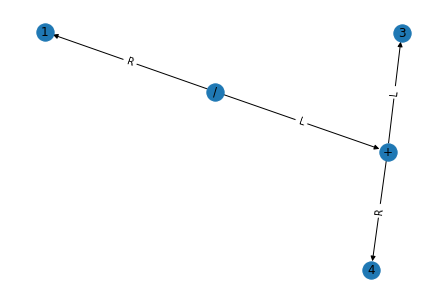

In [12]:
# expr = '1/(4+3)'
# heads = [1, -1, 4, 4, 1, 4, 4]

expr = '(3+4)/1'
heads = [2, 2, 5, 2, 2, -1, 5]

# expr = '3-4'
# heads = [1, -1, 1]

g = sample2graph(expr, heads, node_attr=NODE_ATTR)

pos = nx.spring_layout(g)
nx.draw(g, pos)
node_labels = nx.get_node_attributes(g,'sym')
nx.draw_networkx_labels(g, pos, labels = node_labels)
edge_labels = nx.get_edge_attributes(g,'dir')
nx.draw_networkx_edge_labels(g, pos, edge_labels)

# sample = RelationalSample(g, name='test', node_attr=NODE_ATTR)
sample = TreeSample(expr, heads, node_attr=NODE_ATTR)
print(len(sample.compounds))
print(sorted(sample.compounds, key=lambda x: len(str(x))))

In [13]:
train_exprs = [y for x in train_exprs for y in x]
mcd_exprs = [y for x in mcd_exprs for y in x]
print(len(train_exprs), len(mcd_exprs))
max_nodes_per_compound = 5
max_depth_compound = float('inf')

train_samples = [TreeSample(expr=x[0], heads=x[1], name = f'train_{i}', node_attr=NODE_ATTR,
                          max_nodes_per_compound = max_nodes_per_compound, max_depth_compound=max_depth_compound)
                        for i, x in enumerate(train_exprs)]
mcd_samples = [TreeSample(expr=x[0], heads=x[1], name = f'mcd_{i}', node_attr=NODE_ATTR,
                          max_nodes_per_compound = max_nodes_per_compound, max_depth_compound=max_depth_compound)
                        for i, x in enumerate(mcd_exprs)]

80400 34000


In [14]:
train_samples_partial = random.sample(train_samples, k=len(train_samples))
mcd_samples_partial = random.sample(mcd_samples, k=len(mcd_samples))

In [ ]:
pool_size = len(train_samples_partial) + len(mcd_samples_partial)
n_selected = 10000
max_compounds = 3000
cfg = DBCASplitterConfig(d_a=0.02, d_c=1.0, pool_size=pool_size, num_processes=1,
                         n_sample_per_step=100, max_compounds=max_compounds, use_compound_weight=True,
                         n_train=len(train_samples_partial), n_test=n_selected, save_dir="tmp", verbose=False)
if cfg.num_processes > 1:
    spg = DBCASplitterRay(train_samples_partial + mcd_samples_partial, cfg)
else:
    spg = DBCASplitter(train_samples_partial + mcd_samples_partial, cfg)
for sample in train_samples_partial:
    spg.add_sample_to_set(sample.id, spg.train_set)
spg.generate_splits()

if cfg.num_processes > 0:
    import ray
    ray.shutdown()

INFO:dbca.config:Setting logging level to 20
INFO:dbca.storage:Loading samples into storage...
100%|█████████████████████████| 114400/114400 [00:15<00:00, 7384.39it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 114400 samples...
100%|████████████████████████| 114400/114400 [00:09<00:00, 11488.07it/s]
INFO:dbca.full_sample_set:Computing weight for all 412294 compounds...
  0%|                         | 9/412294 [30:01<27117:30:36, 236.79s/it]

In [ ]:
100%|████████████████████████████████| 20/20 [1:33:16<00:00, 279.83s/it]
INFO:dbca.dbca_splitter:Finished creating dataset!
INFO:dbca.dbca_splitter:Train set size: 4400, test set size: 2000
INFO:dbca.dbca_splitter:D_A: 0.024547835836791543, D_C: 0.2191601685310356
INFO:dbca.dbca_splitter:Saving to test_reg...
INFO:dbca.dbca_splitter:Done!

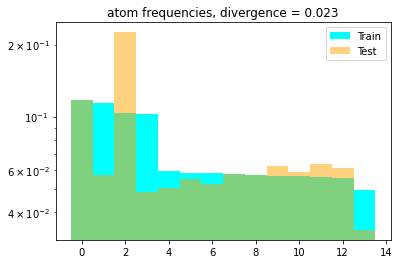

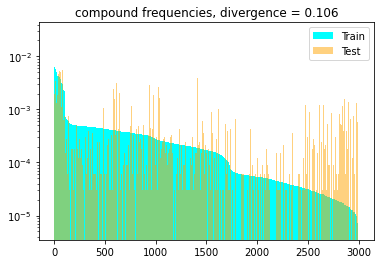

<module 'matplotlib.pyplot' from '/home/qing/.virtualenvs/hint/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [17]:
spg.visualize_dists('atom')
spg.visualize_dists('compound')

In [18]:
len(spg.test_set.sample_ids)

1500

In [6]:
split2dataset = {}
for split in splits:
    split2dataset[split] = json.load(open('expr_%s.json'%split))
    
split2symset = {}
for split in splits:
    split2symset[split] = json.load(open('sym_%s.json'%split))

In [15]:
max_nodes_per_compound = 5
max_depth_compound = 3
split2samples = {}

def map_number(expr):
    return ['n' if x in num_list else x for x in expr]

for split in splits:
    samples = [TreeSample(expr=x['expr'], heads=x['head'], name = f'{split}_{i}', node_attr=NODE_ATTR,
                          max_nodes_per_compound = max_nodes_per_compound, max_depth_compound=max_depth_compound) 
                     for i, x in enumerate(split2dataset[split])]
    split2samples[split] = samples

In [16]:
train_samples = split2samples['train']
all_samples = []
for split in splits:
    all_samples.extend(split2samples[split])
spg = DBCASplitter(all_samples, DBCASplitterConfig(use_compound_weight=False, max_compounds=3000))
for sample in tqdm(train_samples):
    spg.add_sample_to_set(sample.id, spg.train_set)

INFO:dbca.config:Setting logging level to 20
INFO:dbca.storage:Loading samples into storage...
100%|██████████████████████████| 137040/137040 [04:57<00:00, 461.19it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 137040 samples...
100%|████████████████████████| 137040/137040 [00:07<00:00, 18091.81it/s]
INFO:dbca.full_sample_set:Computing weight for all 141218 compounds...
100%|████████████████████████| 141218/141218 [00:03<00:00, 41218.28it/s]
INFO:dbca.full_sample_set:Keeping 3000/141218 highest weighted compounds.
100%|████████████████████████████| 84900/84900 [02:55<00:00, 484.21it/s]


In [17]:
for split in ['val', 'test']:
    samples = split2samples[split]
    dataset = split2dataset[split]
    for evaluation in ['I', 'SS', 'LS', 'SL', 'LL']:
        samples_eval = [x for x, y in zip(samples, dataset) if y['eval'] == evaluation]
        spg.test_set = SplitSampleSet(split="test")
        for sample in samples_eval:
            spg.unused_sample_ids.add(sample.id)
            spg.add_sample_to_set(sample.id, spg.test_set)
        print(f'{split}-{evaluation} ({len(samples_eval)}): AD {spg.atom_divergence}, CD {spg.compound_divergence}')

val-I (1100): AD 0.0003368805202171865, CD 0.012029658292481482
val-SS (800): AD 0.0003081636915347463, CD 0.012583214123693454
val-LS (1000): AD 0.0007648573642786705, CD 0.00857139801803608
val-SL (800): AD 0.05439624062393833, CD 0.08827668382464127
val-LL (1000): AD 0.01202623288196114, CD 0.03414709208166844
test-I (12900): AD 0.0001995788430643186, CD 0.0012403373019348463
test-SS (8000): AD 3.024638359661047e-05, CD 0.001357271118742509
test-LS (10000): AD 0.0006629669778629443, CD 0.005499056365079857
test-SL (6540): AD 0.046040251197732696, CD 0.07326302759684467
test-LL (10000): AD 0.011351363050201235, CD 0.030760354883142327


In [23]:
len(sorted(spg.full_sample_set.compound_weights.items(), key=lambda x: -x[1]))

3000